# Multi Layer perceptron

There are actually two important things here:
1. The perceptron and multi layer perceptron
2. The backpropagation algoritm 


In [189]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [111]:
class PerceptronLayer(nn.Module):
    def __init__(self, input_size, layer_size):
        super().__init__()
        # # Register the weight and bias as parameters
        self.weight = nn.Parameter(torch.empty(input_size, layer_size))
        self.bias = nn.Parameter(torch.empty(layer_size))
        
        # Initialize the parameters
        nn.init.xavier_normal_(self.weight)
        nn.init.uniform_(self.bias, -1, 1)
                
    def forward(self, x):
        return  x @ self.weight + self.bias
    
    def backward(self, dLdy, x):
        # Note: We do not need actualy to do this.
        # The PyTorch Autograd will calcualte gradients for us.
        
        # Anyway, here we want to calculate the gradients.
        # As an input we get the dL/dy - gradient of loss with respect to the output of this layer
        # First we calculate gradient of loss with respect to input to this layer:
        # dL/dx = dL/dy . dy/dx
        # since y = x W + b
        # dL/dx = dL/dy . W^T
        # the matrix calculus gives the derivative as transpose
        
        dLdx = dLdy @ self.weight.T
        
        # Now we need to calcualte gradients with respect to weights and biases
        # dL/dW and dL/db
        # dL/dW = dL/dy . dy/dW
        # dy/dW = x^T
        # and for biases
        # dL/db = dL/dy . dy/db
        # dy/db = 1
        
        dLdW = dLdy @ x.T
        dLdb = dLdy
        
        self.weight.grad = dLdW
        self.bias.grad = dLdb.sum(dim=0)
        
        return dLdx        

In [159]:
# Testing
batch_size = 32
input_size = 4
layer_size = 16
pl = PerceptronLayer(input_size, layer_size)
x = torch.rand(batch_size, input_size)
y = pl(x)

Let's create a simple neural network and train it on some data

In [201]:
digits = load_digits()
X, y = digits['data'], digits['target']

# Split data into 50% train and 50% test subsets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, shuffle=False
)
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.long)

In [202]:
print(X.shape, y.shape)

(1797, 64) (1797,)


In [203]:
epochs = 5
neural_net = nn.Sequential(PerceptronLayer(64,32),PerceptronLayer(32,10))
optimizer = torch.optim.SGD(neural_net.parameters(), lr=1.e-3)

loss_history = []
for _ in range(epochs):
    for sample_id, sample in enumerate(zip(X_train, y_train)):
        x_sample, y_sample = sample

        optimizer.zero_grad()
        y_prime = neural_net(x_sample)
        loss = nn.functional.cross_entropy(y_prime, y_sample)
        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()        

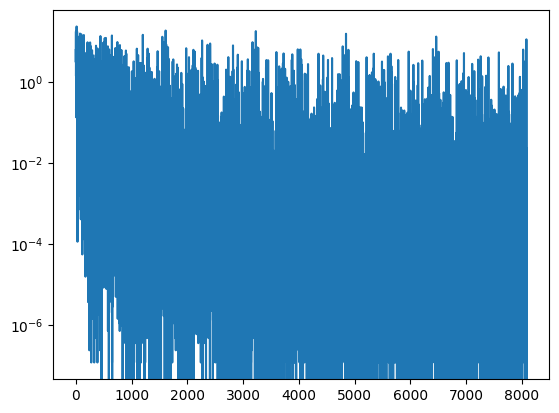

In [204]:
plt.figure()
plt.plot(loss_history)
plt.yscale('log')
plt.show()

In [205]:
# After training, make predictions
neural_net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Make predictions on the training set (or validation/test set)
    y_pred = neural_net(X_test)
    y_pred_classes = torch.argmax(y_pred, dim=1)  # Get predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test.numpy(), y_pred_classes.numpy())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
report = classification_report(y_test.numpy(), y_pred_classes.numpy())
print("Classification Report:")
print(report)

Confusion Matrix:
[[16  0  0  0  0  0  0  0  0  0]
 [ 0 16  0  0  1  0  0  0  2  0]
 [ 0  0 16  1  0  0  0  0  0  0]
 [ 0  0  0 14  0  2  0  0  2  0]
 [ 0  1  0  0 18  0  0  0  0  1]
 [ 0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0]
 [ 0  0  0  2  0  0  0  0 15  0]
 [ 0  0  0  2  0  1  0  0  0 15]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      0.84      0.89        19
           2       1.00      0.94      0.97        17
           3       0.74      0.78      0.76        18
           4       0.95      0.90      0.92        20
           5       0.86      1.00      0.92        18
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        19
           8       0.79      0.88      0.83        17
           9       0.94      0.83      0.88        18

    accuracy                    

In [206]:
epochs = 5
batch_size = 32
neural_net = nn.Sequential(PerceptronLayer(64,32),PerceptronLayer(32,10))
optimizer = torch.optim.Adam(neural_net.parameters(), lr=1.e-2)

loss_history_batches = []
for _ in range(epochs):
    total_batch_number = torch.ceil(torch.tensor(X_train.size(0)/batch_size)).to(int).item()
    for idx in range(total_batch_number):
        sample_start_idx = idx*batch_size
        if (idx+1)*batch_size < X_train.size(0):
            sample_end_idx = (idx+1)*batch_size
        else:
            sample_end_idx = X_train.size(0)-1
            
        X_batch = X_train[sample_start_idx: sample_end_idx,:]
        y_batch = y_train[sample_start_idx: sample_end_idx]
        

        optimizer.zero_grad()
        y_prime = neural_net(X_batch)
        loss = nn.functional.cross_entropy(y_prime, y_batch)
        loss_history_batches.append(loss.item())
        loss.backward()
        optimizer.step()        

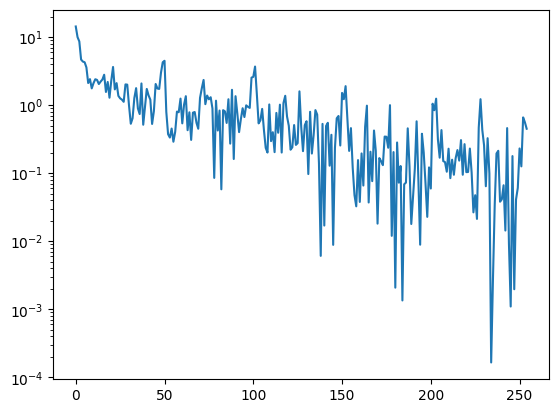

In [207]:
plt.figure()
plt.plot(loss_history_batches)
plt.yscale('log')
plt.show()

In [208]:
# After training, make predictions
neural_net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    # Make predictions on the training set (or validation/test set)
    y_pred = neural_net(X_test)
    y_pred_classes = torch.argmax(y_pred, dim=1)  # Get predicted class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test.numpy(), y_pred_classes.numpy())

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Compute classification report
report = classification_report(y_test.numpy(), y_pred_classes.numpy())
print("Classification Report:")
print(report)

Confusion Matrix:
[[16  0  0  0  0  0  0  0  0  0]
 [ 0 19  0  0  0  0  0  0  0  0]
 [ 0  0 17  0  0  0  0  0  0  0]
 [ 0  0  1 13  0  2  0  0  2  0]
 [ 0  1  0  0 18  0  0  0  0  1]
 [ 0  1  0  0  0 17  0  0  0  0]
 [ 0  1  0  0  0  0 17  0  0  0]
 [ 0  0  0  0  0  0  0 19  0  0]
 [ 0  4  0  0  0  0  0  0 13  0]
 [ 0  0  0  1  0  1  0  0  1 15]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.73      1.00      0.84        19
           2       0.94      1.00      0.97        17
           3       0.93      0.72      0.81        18
           4       1.00      0.90      0.95        20
           5       0.85      0.94      0.89        18
           6       1.00      0.94      0.97        18
           7       1.00      1.00      1.00        19
           8       0.81      0.76      0.79        17
           9       0.94      0.83      0.88        18

    accuracy                    